# 306_4 Anomaly Detection

<div>
<img align="left" src="attachment:90083a24-00a4-4a6f-a1c3-b9b4c6b0de9e.png" width="300" style="padding-right: 20px;"/>
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-8-6 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** Illustrate the use of Machine Learning techniques for anomaly detection with DP1 data.

**LSST data products:** 

**Packages:**  `lsst`, `scikit-learn, pandas, matplotlib, numpy, astropy,

**Credit:** Originally developed by the Rubin Community Science team.
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.


Based on notebook prepared for Rubin Community Workshop 2025 by by Siddharth Chaini, Andres A. Plazas Malagón, Ryan Lau, Tatiana Acero Cuellar and input from Fed. Bianco. 

Gaia section: Tatiata, Sid


**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

1. apply the IsolationForest routine from [`scikit-learn`](https://scikit-learn.org/stable/)
2. Run custom code by Sid based on different metrics in latent space. 

### 1.1. Import packages

Import general python packages, the IsolationForest algorithm from `scikit-learn`, and the Rubin TAP service utilities.

The [`matplotlib`](https://matplotlib.org/), [`numpy`](http://www.numpy.org/), and [`scikit-learn`](https://scikit-learn.org/stable/) libraries are widely used Python libraries for plotting, scientific computing, and conducting Machine-Learning data analysis. We will use these packages below, including the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

We also use the `lsst.rsp` package to access the TAP service and query the DP1 catalogs.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsst.rsp import get_tap_service
from lsst.utils.plotting import (
    get_multiband_plot_colors,
    get_multiband_plot_symbols,
)
from sklearn.ensemble import IsolationForest

### 1.2. Define parameters and functions.

Create an instance of the TAP service, and assert that it exists.

In [56]:
service = get_tap_service("tap")
assert service is not None

Define parameters to use colorblind-friendly colors with `matplotlib`.

In [57]:
plt.style.use('seaborn-v0_8-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Define colors, symbols, and linestyles to represent the six LSST filters, $ugrizy$.

In [58]:
filter_names = ["u", "g", "r", "i", "z", "y"]
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

## 2. Search for Anomalous DiaObjects using IsolationForest

Apply the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) from  `scikit-learn` on the DP1 `DiaObject` catalog to identify anomalous sources. 

Look for DiaObjects that are anomalously variable, and then inspect their light curves. 

To reduce spurious DiaObjects, we set a minimum number of DiaSource detections.

In [59]:
ndiasources_min = 10

Focus the search for anomalous behavior from DiaObjects in the r-band.

In [60]:
band = 'r'

set an additional threshold for number of detections in the r-band filter.

In [63]:
ndata_thresh = 8

Retrieve DiaObjects and the following statistics of their r-band light curve:

**rPSFluxNdata:** The number of data points used to compute rPSFluxChi2. <br>
**rPSFluxSigma:** The standard deviation of the fluxes. <br>
**rPSFluxLinearSlope:** Slope of a linear model fit to diaSource PSF flux vs time.<br>
**rPSFluxMean:** The average flux. <br>

Note that the statistics are all based on the _difference-image point source (PS) flux values_.

An r-band total mean flux (`rTOTFluxMean`) threshold of $<1\times10^5$ nJy is set to filter out saturated sources. Limits are also placed on the maximum r-band difference-image flux (`rPSFluxMax` $<1\times10^5$ nJy) and the minimum r-band difference-image flux (`rPSFluxMin` $>-1\times10^5$ nJy) to avoid artifacts from saturated sources.

In [64]:
diaobjid_features = [
    f"{band}_psfFluxChi2",
    f"{band}_psfFluxLinearIntercept",
    f"{band}_psfFluxSkew",
    f"{band}_psfFluxStetsonJ",
    f"{band}_psfFluxMean",
    f"{band}_psfFluxLinearSlope",
    f"{band}_psfFluxSigma",
]

In [67]:
query = f"""
SELECT
    diaObjectId, ra, dec,
    {', '.join(diaobjid_features)}
FROM
    dp1.DiaObject
WHERE
    nDiaSources > {ndiasources_min}
    AND r_psfFluxNdata > {ndata_thresh}
    AND r_scienceFluxMean < 1e5
"""

In [68]:
job = service.submit_job(query)
job.run()
job.wait(phases=["COMPLETED", "ERROR"])
if job.phase == "ERROR":
    job.raise_if_error()

In [69]:
assert job.phase == "COMPLETED"
dia_objects = job.fetch_result().to_table().to_pandas().set_index("diaObjectId")

print(f"Retrieved {len(dia_objects)} DiaObjects.")

Retrieved 8569 DiaObjects.


### 2.2. Run IsolationForest Algorithm

We run the [Isolation Forest Algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) on the DiaObject sample and look for outliers based on the `rPSFluxMean`, `rPSFluxLinearSlope`, and `rPSFluxSigma`values. The algorithm outputs anomaly scores based on the input sample where negative scores represent outliers.

The indices of the top 20 outliers are saved in the array `idx`.

From [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html),
> The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
<div align="center">
<img src="media/iforest.gif" alt="Animation of Isolation Forest partitioning data" width="450"/>
<br>
<em>Fig: A simplified model of how an isolation forest makes cuts on the features randomly - anomalous points require less cuts to isolate.</em>
</div>

In [70]:
sample = dia_objects.to_numpy()

In [71]:
rng = np.random.RandomState(42)
ifo = IsolationForest(max_samples=500, random_state=rng)
ifo.fit(sample)

,n_estimators,100
,max_samples,500
,contamination,'auto'
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,RandomState(M...0x77FEB02F9B40
,verbose,0
,warm_start,False


In [72]:
scores = ifo.score_samples(sample)
outlier_indices = np.argsort(scores)[:20]

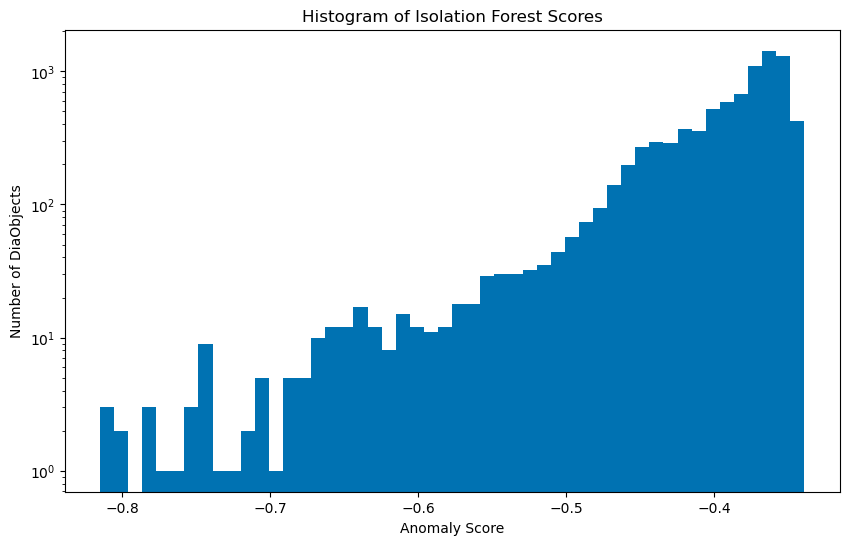

In [73]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of Isolation Forest Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [14]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [74]:
outlier_diaobject_ids

Index([628761153182368124, 604063373243449915, 579576699537065212,
       604062754768159284, 579576699537066732, 579576699537065765,
       579577249292878807, 579578005207126000, 611255210081255577,
       579577386731832906, 579577249292878245, 579578005207122694,
       579576630817588401, 579578005207122878, 648366338858811406,
       579577936487647676, 579578005207121996, 579578073926599605,
       579576630817587953, 611254522886488089],
      dtype='int64', name='diaObjectId')

In [15]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

In [16]:

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

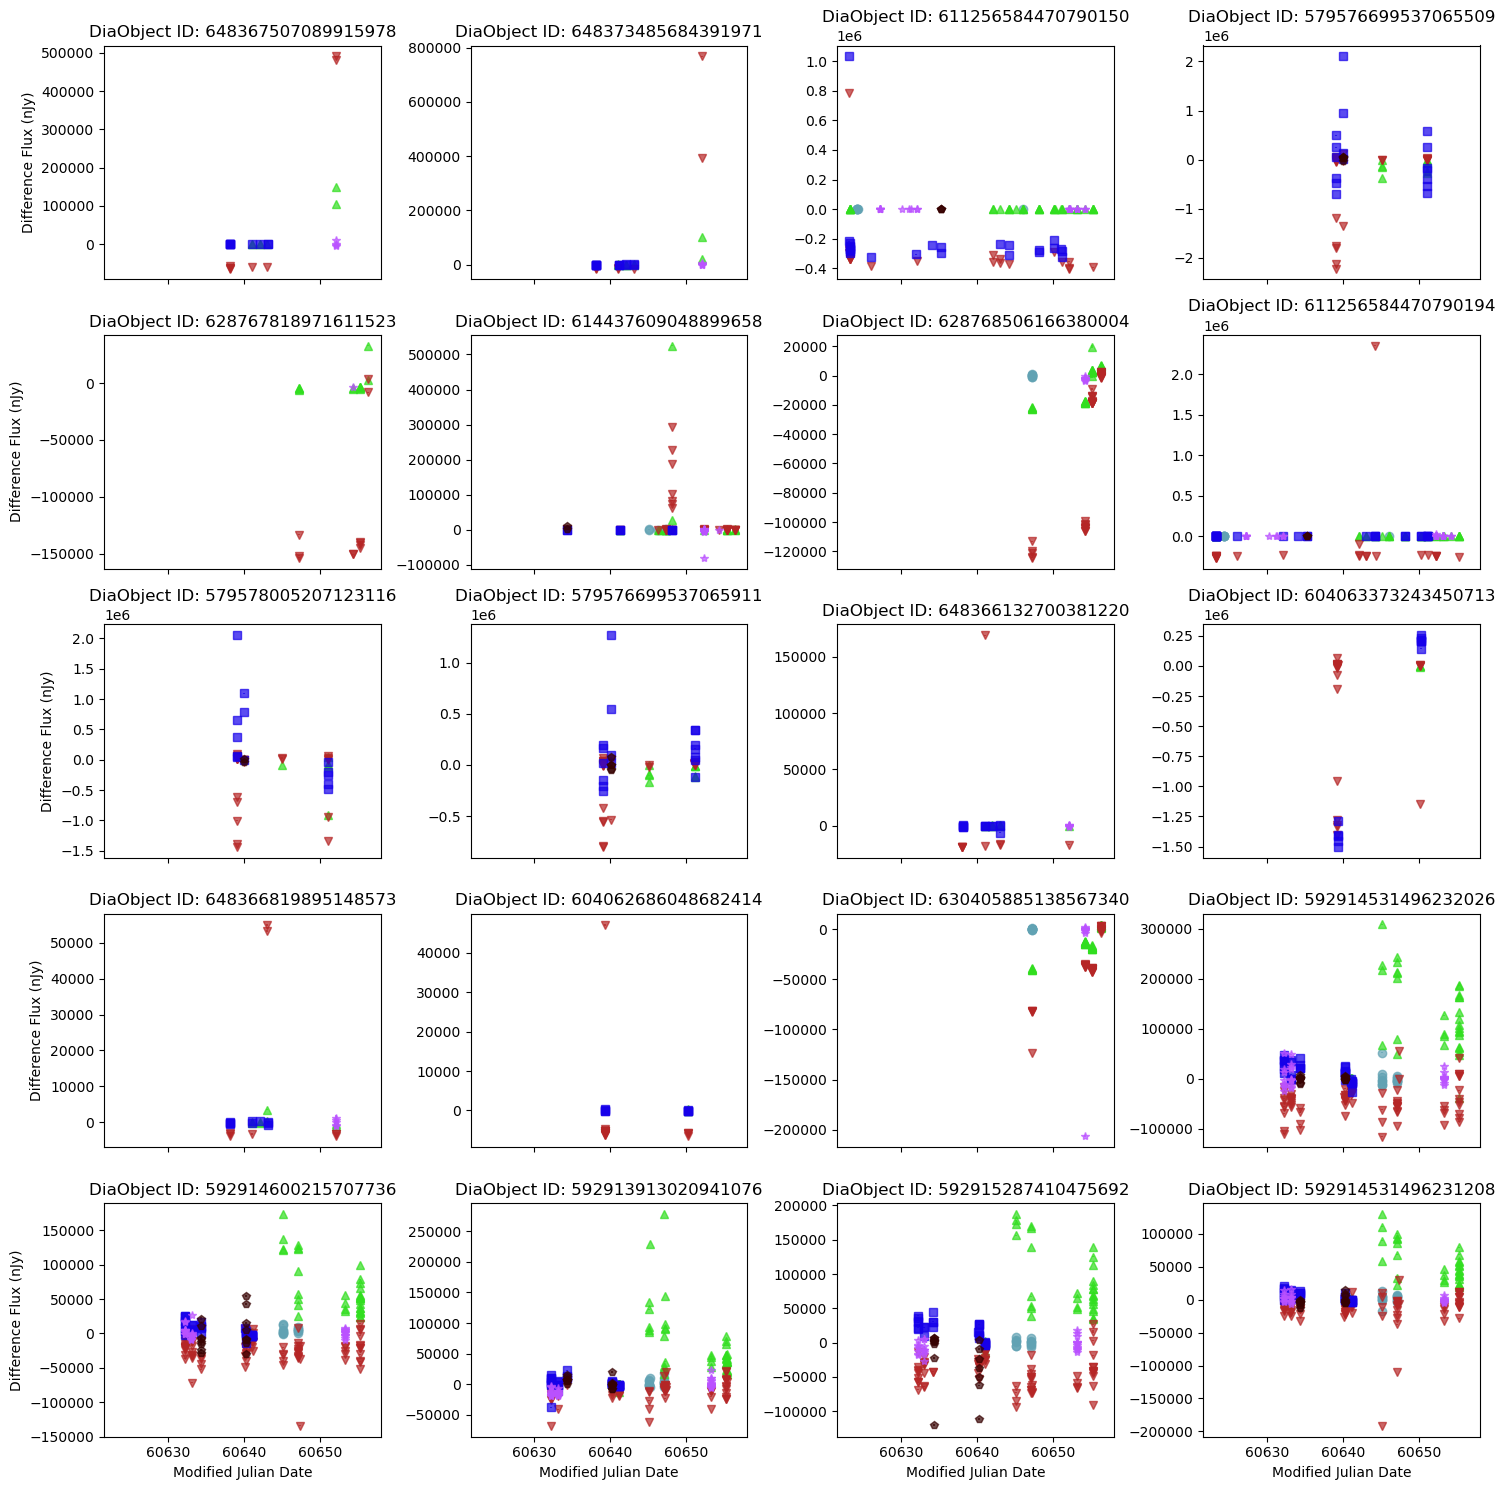

In [17]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

In [18]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 37.99417473077787
  Dec: 7.2739802663929956
  r-band PSF Flux Mean: -44337.1875
  r-band PSF Flux Sigma: 282457.5359111508
  r-band PSF Flux Linear Slope: 25423.938938181407


Add comments about analysis

In [20]:
# for top_outlier_id in outlier_diaobject_ids:
#     top_outlier_data = dia_objects.loc[top_outlier_id]
#     print(f"  DiaObject ID: {top_outlier_id}")
#     print(f"  RA, DEC: {top_outlier_data['ra']} {top_outlier_data['dec']}")
#     print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
#     print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
#     print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")
#     print("*"*20)

## 3. Run DistClassiPy: Anomalies

<div align="center">
<img src="media/dcpy-anomalies.gif" alt="Animation of DistClassiPy's anomaly detection method" width="450"/>
<br>
<em>Fig: A simplified model of how multiple distance metrics can be used to flag points which are far away from known classes.</em>
</div>



In [21]:
!pip install git+http://github.com/sidchaini/distclassipy
# pip install distclassipy

Defaulting to user installation because normal site-packages is not writeable
  Cloning http://github.com/sidchaini/distclassipy to /tmp/pip-req-build-1cmb8a05
  Running command git clone --filter=blob:none --quiet http://github.com/sidchaini/distclassipy /tmp/pip-req-build-1cmb8a05
  Resolved http://github.com/sidchaini/distclassipy to commit dbd4d98dc1a8aad8f02bfa622dc3c46766fa211a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for distclassipy: filename=distclassipy-0.2.2a3-py3-none-any.whl size=46265 sha256=64bf14ddffd3d80272411201d61c8ecd61e61262f7bdb9b57ae1ca9fe0b59744
  Stored in directory: /tmp/pip-ephem-wheel-cache-n_gei31t/wheels/07/e2/ba/21dcc370b4b76344af8717cc5b1e3d0c7799c450f26e7085a2
Successfully built distclassipy


In [22]:
from distclassipy.anomaly import DistanceAnomaly

Now, we also need some labels for DistClassiPy to find an anchor to "known" classes. We can do this by cross matching DP1 with Gaia data (see ```2. gaia dp1 xmatch.ipynb```).

Here, let's load the cross match table generated in the other notebook.

In [37]:
from lsst.daf.butler import Butler

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

import matplotlib.pyplot as plt
import astropy
import numpy as np
import os
import pandas as pd
import gc

import pandas as pd
import getpass
import matplotlib
from astropy.time import Time
from tqdm.auto import tqdm

import io
import re

In [27]:
butler = Butler("dp1", collections="LSSTComCam/DP1")

In [28]:
obj_refs = butler.query_datasets("dia_source", limit=None)

In [38]:
matches = pd.DataFrame()
total_sources = 0

for i in tqdm(range(len(obj_refs))):
    try:
        diasource = butler.get(obj_refs[i]).to_pandas()
        max_exp_ra, min_exp_ra = diasource.ra.max(), diasource.ra.min()
        max_exp_dec, min_exp_dec = diasource.dec.max(), diasource.dec.min()

        query = (
            "SELECT cls.source_id, best_class_name, s.ref_epoch, s.ra, s.dec FROM gaiadr3.vari_classifier_result AS cls "
            "LEFT OUTER JOIN gaiadr3.gaia_source AS s ON s.source_id=cls.source_id "
            f"WHERE ra BETWEEN {min_exp_ra} AND {max_exp_ra} "
            f"AND dec BETWEEN {min_exp_dec} AND {max_exp_dec}"
        )
        # Launch the query asynchronously
        job = Gaia.launch_job_async(query=query)
        results = job.get_results()

        results = results.to_pandas()

        catalog = SkyCoord(ra=results["ra"], dec=results["dec"], unit=u.deg)
        detections_cat = SkyCoord(ra=diasource.ra, dec=diasource.dec, unit=u.deg)

        idx, sep2d, dist3d = detections_cat.match_to_catalog_sky(catalog)
        space_match_threshold = 1 * u.arcsec
        diasource_mask = sep2d < space_match_threshold
        print(
            f"{np.sum(diasource_mask)} of {len(detections_cat)} matched after applying spatial threshold"
        )

        total_sources = total_sources + np.sum(diasource_mask)
        if np.sum(diasource_mask) > 0:
            # Get all matched
            matched_diasource_idx = idx[
                diasource_mask
            ]  # index in stars of matched dia_detections
            dia_idx_diasource = diasource.index[diasource_mask]

            diasource.loc[dia_idx_diasource, "id_match"] = results.loc[
                matched_diasource_idx, "source_id"
            ].to_numpy()
            diasource.loc[dia_idx_diasource, "best_class_name"] = results.loc[
                matched_diasource_idx, "best_class_name"
            ].to_numpy()

            matches = pd.concat([matches, diasource[~diasource["id_match"].isna()]])

    except Exception as e:
        print(e)
print(f"Total of matches {total_sources}")

  0%|          | 0/25 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]


1594 of 611489 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


501 of 55209 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


78 of 19659 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


2 of 15 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


1141 of 237904 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


3772 of 127808 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


208 of 9526 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


4 of 379 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


157 of 10622 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


784 of 47942 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


1167 of 102217 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


6338 of 401814 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


The catalog for coordinate matching cannot be a scalar or length-0.
INFO: Query finished. [astroquery.utils.tap.core]


3 of 914 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


1020 of 95980 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


2615 of 252770 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


5615 of 460190 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


987 of 124617 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


2924 of 210345 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


10 of 1481 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


1552 of 209774 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


732 of 57726 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


232 of 29621 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


87 of 15627 matched after applying spatial threshold
INFO: Query finished. [astroquery.utils.tap.core]


8 of 2773 matched after applying spatial threshold
Total of matches 31531


In [41]:
gaia_xmatch = matches.set_index("diaObjectId")

In [ ]:
# features = pd.read_parquet("../dp1anom/data/dp1_features_sc.parquet")
#gaia_xmatch = pd.read_csv("gaia_matches.csv").set_index("diaObjectId")

In [42]:
common_objs = np.intersect1d(gaia_xmatch.index, dia_objects.index)
print(f"Found {len(common_objs)} objects common in Gaia DR3 and DP1")
gaia_classes = (
    gaia_xmatch.loc[common_objs, ["best_class_name"]]
    .reset_index(drop=False)
    .drop_duplicates()
    .set_index("diaObjectId")
)

Found 160 objects common in Gaia DR3 and DP1


In [43]:
gaia_classes.value_counts()

best_class_name
RR                 43
AGN                38
LPV                38
SOLAR_LIKE         17
ECL                11
RS                  5
YSO                 5
S                   3
Name: count, dtype: int64

In [44]:
y_knowns_df = gaia_classes["best_class_name"]
X_knowns_df = dia_objects.loc[y_knowns_df.index,]

In [45]:
X_unknowns_df = dia_objects.loc[:, X_knowns_df.columns].drop(X_knowns_df.index)

In [46]:
model = DistanceAnomaly(cluster_agg="min", metric_agg="median", normalize_scores=True)

In [47]:
model.fit(X_knowns_df.to_numpy(), y_knowns_df.to_numpy())

,metrics,None
,cluster_agg,'min'
,metric_agg,'median'
,normalize_scores,True
,scale,True
,central_stat,'median'
,dispersion_stat,'std'
,contamination,0.1


In [48]:
scores = -model.decision_function(X_unknowns_df.to_numpy())
outlier_indices = np.argsort(scores)[:20]

In [49]:
outlier_indices = np.argsort(scores)[:20]

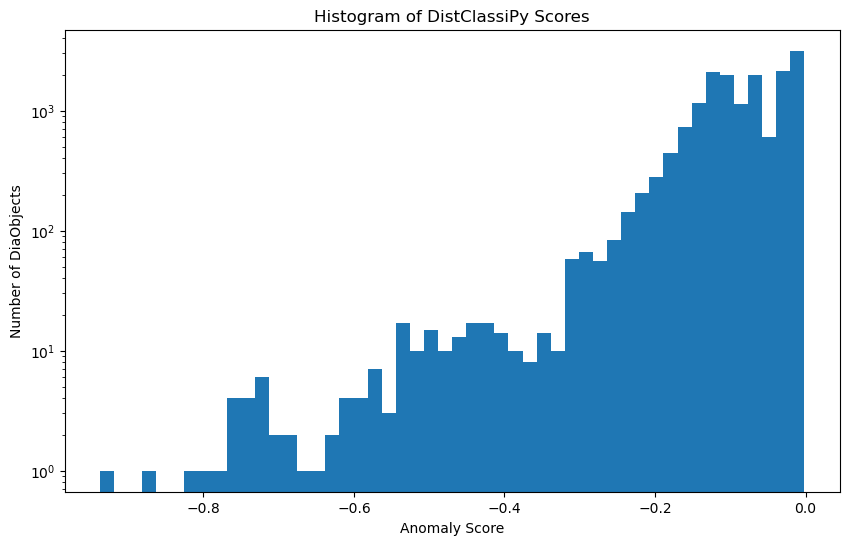

In [50]:
plt.figure(figsize=(10, 6))
plt.title("Histogram of DistClassiPy Scores")
plt.hist(scores, bins=50, log=True)
plt.xlabel("Anomaly Score")
plt.ylabel("Number of DiaObjects")
plt.show()

In [51]:
outlier_diaobject_ids = dia_objects.index[outlier_indices]

In [53]:
query_lightcurves = f"""
SELECT
    fsodo.diaObjectId,
    fsodo.band,
    fsodo.psfDiffFlux,
    fsodo.psfDiffFluxErr,
    vis.expMidptMJD
FROM
    dp1.ForcedSourceOnDiaObject AS fsodo
JOIN
    dp1.Visit AS vis ON vis.visit = fsodo.visit
WHERE
    fsodo.diaObjectId IN ({','.join(map(str, outlier_diaobject_ids))})
"""

job_lightcurves = service.submit_job(query_lightcurves)
job_lightcurves.run()
job_lightcurves.wait(phases=["COMPLETED", "ERROR"])
if job_lightcurves.phase == "ERROR":
    job_lightcurves.raise_if_error()

assert job_lightcurves.phase == "COMPLETED"
forced_source_outliers = job_lightcurves.fetch_result().to_table().to_pandas()

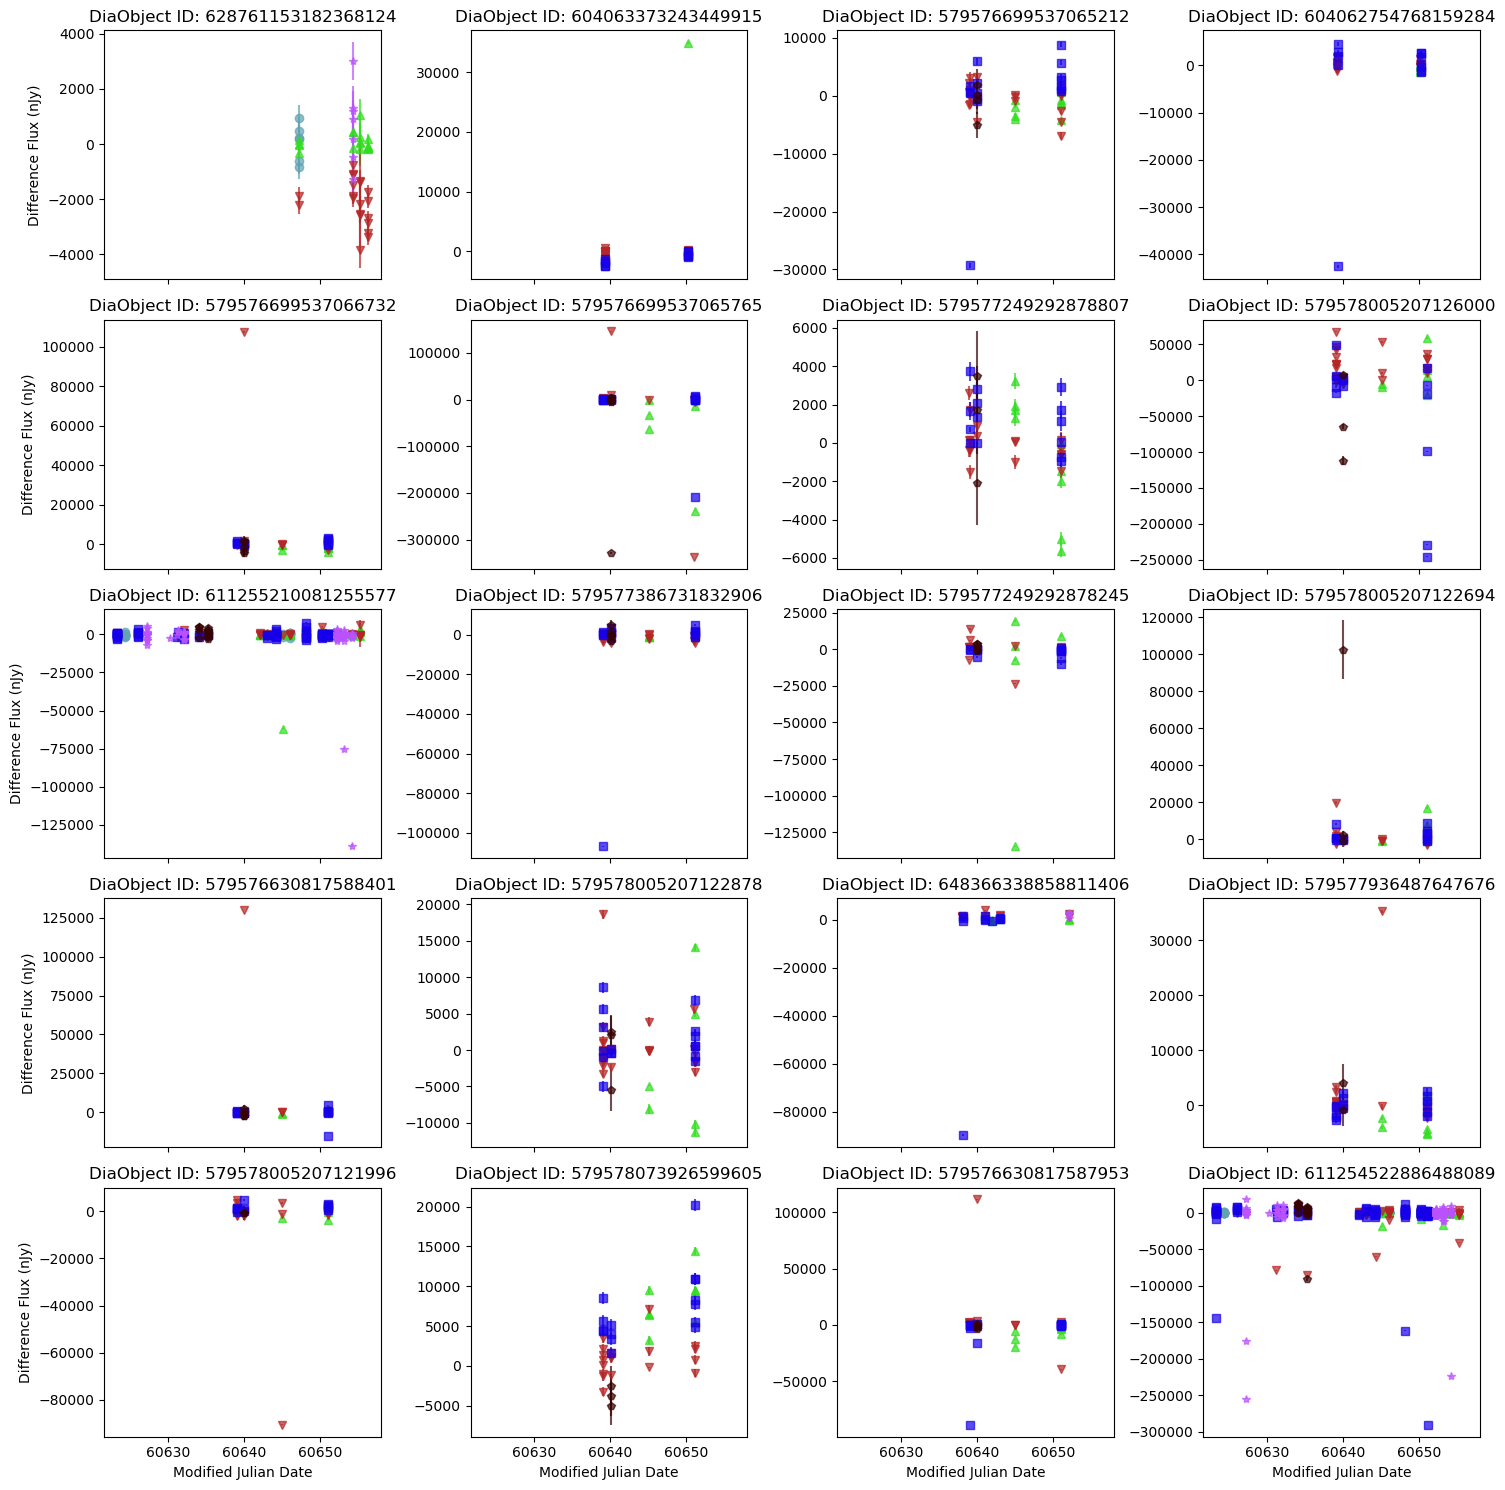

In [54]:
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharex=True)
axes = axes.flatten()

for i, diaobject_id in enumerate(outlier_diaobject_ids):
    ax = axes[i]
    object_data = forced_source_outliers[
        forced_source_outliers["diaObjectId"] == diaobject_id
    ]
    for band in filter_names:
        band_data = object_data[object_data["band"] == band]
        if len(band_data) > 0:
            ax.errorbar(
                band_data["expMidptMJD"],
                band_data["psfDiffFlux"],
                yerr=band_data["psfDiffFluxErr"],
                fmt=filter_symbols[band],
                color=filter_colors[band],
                label=band,
                alpha=0.7,
            )
    ax.set_title(f"DiaObject ID: {diaobject_id}")
    if i >= 16:
        ax.set_xlabel("Modified Julian Date")
    if i % 4 == 0:
        ax.set_ylabel("Difference Flux (nJy)")

plt.tight_layout()
plt.show()

In [55]:
top_outlier_id = outlier_diaobject_ids[0]
top_outlier_data = dia_objects.loc[top_outlier_id]
print("Top Outlier")
print(f"  DiaObject ID: {top_outlier_data.index[0]}")
print(f"  RA: {top_outlier_data['ra']}")
print(f"  Dec: {top_outlier_data['dec']}")
print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")

Top Outlier
  DiaObject ID: ra
  RA: 105.96561702372843
  Dec: -10.687113965156492
  r-band PSF Flux Mean: -2420.23779296875
  r-band PSF Flux Sigma: 755.0641227099654
  r-band PSF Flux Linear Slope: -73.90625336213405


In [ ]:
# for top_outlier_id in outlier_diaobject_ids:
#     top_outlier_data = dia_objects.loc[top_outlier_id]
#     # print("Top Outlier")
#     print(f"  DiaObject ID: {top_outlier_id}")
#     print(f"  RA, DED: {top_outlier_data['ra']} {top_outlier_data['dec']}")
#     print(f"  r-band PSF Flux Mean: {top_outlier_data['r_psfFluxMean']}")
#     print(f"  r-band PSF Flux Sigma: {top_outlier_data['r_psfFluxSigma']}")
#     print(f"  r-band PSF Flux Linear Slope: {top_outlier_data['r_psfFluxLinearSlope']}")
#     print("*"*20)

## 4. Going further

Now, in this tutorial we only used photometric data available from the catalogs. For more detailed analysis, you could use a feature extractor on every light curve. For example: [ALeRCE](https://github.com/alercebroker/pipeline)([Sánchez-Sáez+21](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)) or [```light-curve```]((https://github.com/light-curve/light-curve-python))[(Malanchev+21)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract).

After obtaining these features for your light curve sample, you can perform anomaly detection very similarly to above.